In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, plot_roc_curve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium 

## Important

In order to use run this data you must download the data sets from the following 3 links and store them in the same folder as your notebook
1. https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
2. https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3
3. https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

In [47]:
#importing datasets
df = pd.read_csv('../Traffic_Crashes_-_Crashes.csv')
df_people = pd.read_csv('../Traffic_Crashes_-_People.csv')
df_vehicles = pd.read_csv('../Traffic_Crashes_-_Vehicles.csv')
df.head()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993)
1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,JA329216,NaN,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,07/10/2020 10:25:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,07/11/2020 01:00:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,07/08/2020 02:00:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN


In [48]:
#Merging Datasets on the Crash_Record_ID Column
df_merge = pd.merge(df, df_vehicles, on='CRASH_RECORD_ID').reset_index()
df_merge_2 = pd.merge(df_merge, df_people, on='CRASH_RECORD_ID').reset_index()

#dropping dupllicates(basically only having one instance of the crashID on there)
df_dropped= df_merge_2.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first')

In [49]:
#only accidents with the driver
df_driver = df_dropped[df_dropped['PERSON_TYPE']=='DRIVER']
df_driver = df_driver[(df_driver.VEHICLE_YEAR>=1970) & (df_driver.VEHICLE_YEAR <=2021)]

#necessary columns
new_columns = ['AGE', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT',
           'WEATHER_CONDITION','LIGHTING_CONDITION','TRAFFIC_CONTROL_DEVICE',
           'PHYSICAL_CONDITION','VEHICLE_DEFECT', 'LONGITUDE', 'LATITUDE','INJURIES_FATAL']

#Dataframe with the new columns
df_driver = df_driver[new_columns]

In [50]:
#dropping missing values
df_driver.dropna(axis=0, subset=['LATITUDE'], inplace =True)
df_driver.dropna(axis=0, subset=['LONGITUDE'], inplace =True)

In [51]:
df_driver = df_driver[(df_driver.WEATHER_CONDITION != 'UNKNOWN')|
                      (df_driver.WEATHER_CONDITION != 'OTHER')|
                      (df_driver.WEATHER_CONDITION != 'BLOWING SAND, SOIL, DIRT')]
df_driver = df_driver[df_driver.LIGHTING_CONDITION != 'UNKNOWN']
df_driver = df_driver[(df_driver.TRAFFIC_CONTROL_DEVICE != 'UNKNOWN')|(df_driver.TRAFFIC_CONTROL_DEVICE != 'OTHER')]
df_driver = df_driver[(df_driver.PHYSICAL_CONDITION != 'UNKNOWN')|(df_driver.PHYSICAL_CONDITION != 'OTHER')]

In [52]:
df_driver.INJURIES_FATAL.replace({0.0:0, 1.0:1, 2.0:1, 3.0:1, 4.0:1}, inplace=True)
df_driver.AGE.replace({np.NAN: df_driver.AGE.median()},inplace=True)

In [53]:
df_driver.shape

(390699, 13)

# Data Preperation

In [54]:
X = df_driver.drop('INJURIES_FATAL',axis=1)
y = df_driver.INJURIES_FATAL

# train-test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### One Hot Encoding 

In [58]:
#Ohe-ing Train set
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums_train = ohe.fit_transform(X_train_cat)
dums_train_df = pd.DataFrame(dums_train,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

nums_train_df = X_train.select_dtypes(['int64','float64'])

X_train_clean = pd.concat([nums_train_df, dums_train_df], axis=1)

In [59]:
#Ohe-ing Test set
X_test_cat = X_test.select_dtypes('object')

dums_test = ohe.transform(X_test_cat)
dums_test_df = pd.DataFrame(dums_test,
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)

nums_test_df = X_test.select_dtypes(['int64','float64'])

X_test_clean = pd.concat([nums_test_df, dums_test_df], axis=1)

### Smote

In [60]:
# X_train_clean.columns
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_clean, y_train) 

# Decision Tree

In [61]:
tree = DecisionTreeClassifier()

In [62]:
tree_grid = {'max_leaf_nodes': [2,3,4,5], 
             'min_samples_split': [2, 3, 4],
             'max_depth': [3,4,5, 6, 7, 8, 9],
            }


In [63]:
tree_grid_search = GridSearchCV(tree, tree_grid, cv=5)

In [64]:
tree_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4]})

In [106]:
tree_grid_search.best_params_

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}

In [107]:
tree_grid_search.best_score_

0.8860254176488676

In [108]:
tree_grid_search.best_estimator_.score(X_test_clean, y_test)

0.9067315075505503

In [109]:
best_tree = tree_grid_search.best_estimator_

In [110]:
tree_test_preds = best_tree.predict(X_test_clean)

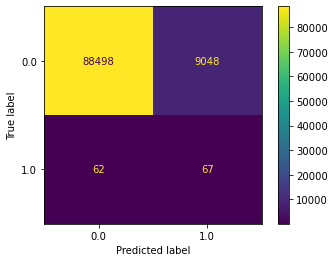

In [111]:
plot_confusion_matrix(best_tree, X_test_clean, y_test, values_format = '');

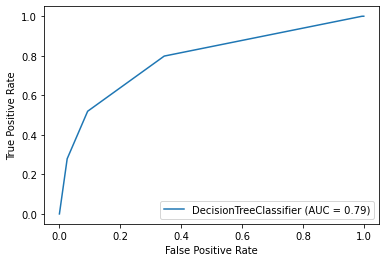

In [112]:
plot_roc_curve(best_tree, X_test_clean, y_test);

In [113]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [114]:
print_metrics(y_test, tree_test_preds)

Precision Score: 0.007350521119034559
Recall Score: 0.5193798449612403
Accuracy Score: 0.9067315075505503
F1 Score: 0.014495889225443532


In [115]:
tree_features = list(zip(best_tree.feature_importances_, X_train_resampled.columns.values))
tree_features = [x for x in tree_features if x[0] > 0]
tree_features = sorted(tree_features, key=lambda x: x[0], reverse=True)
tree_features_values = [x[0] for x in tree_features]
tree_features_names = [x[1] for x in tree_features]

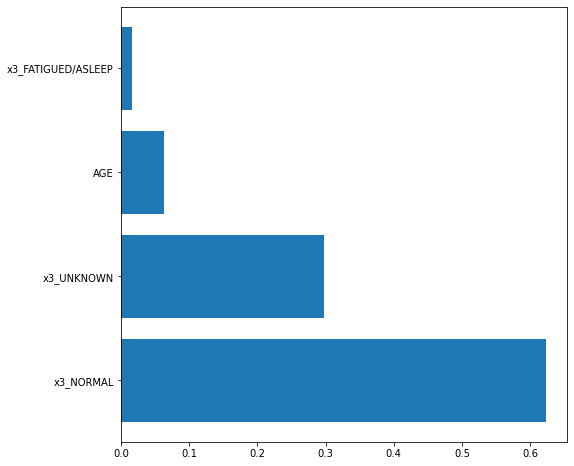

In [116]:
plt.figure(figsize=(8,8))
# tree_labels = ['Physical Condition: Normal', 'Lighting Conditioning: Unknown',
#             'Physical Condition: Unknown', 'Physical Condition: Fatigued/Asleep']
# , tick_label=tree_labels
plt.barh(tree_features_names, tree_features_values, align='center')
plt.ylabel('');

In [117]:
tree_cv_df = pd.DataFrame(tree_grid_search.cv_results_)
tree_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.888384,0.026824,0.017344,0.000123,3,2,2,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802655,0.800707,0.802057,0.802458,0.800135,0.801602,0.001000,64
1,1.038564,0.232942,0.019874,0.003861,3,2,3,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802655,0.800707,0.802057,0.802458,0.800135,0.801602,0.001000,64
2,0.879990,0.007196,0.017495,0.000201,3,2,4,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802655,0.800707,0.802057,0.802458,0.800135,0.801602,0.001000,64
3,1.147282,0.007502,0.017594,0.000794,3,3,2,"{'max_depth': 3, 'max_leaf_nodes': 3, 'min_sam...",0.850424,0.851722,0.851440,0.851414,0.850116,0.851023,0.000632,43
4,1.154025,0.016334,0.017445,0.000379,3,3,3,"{'max_depth': 3, 'max_leaf_nodes': 3, 'min_sam...",0.850424,0.851722,0.851440,0.851414,0.850116,0.851023,0.000632,43


# Random Forest

In [77]:
forest = RandomForestClassifier()

In [78]:
# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2']

# function to measure the quality of a split
# criteria = ['gini', 'entropy']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
forrest_grid = {'max_features': max_features,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [79]:
forrest_grid_search = GridSearchCV(estimator=forest, param_grid=forrest_grid, cv=5)

In [80]:
forrest_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [91]:
forrest_grid_search.best_params_

{'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

In [92]:
forrest_grid_search.best_score_

0.9994431348433604

In [93]:
forrest_grid_search.best_estimator_.score(X_test_clean, y_test)

0.9986485794727412

In [94]:
best_forest = forrest_grid_search.best_estimator_

In [95]:
forrest_test_preds = forrest_grid_search.predict(X_test_clean)

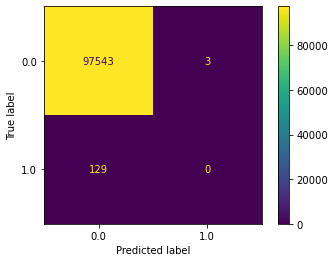

In [96]:
plot_confusion_matrix(best_forest, X_test_clean, y_test, values_format='');

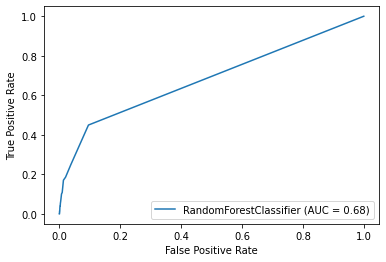

In [97]:
plot_roc_curve(best_forest, X_test_clean, y_test);

In [98]:
print_metrics(y_test, forrest_test_preds)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.9986485794727412
F1 Score: 0.0


In [101]:
# np.set_printoptions(formatter={'float_kind':'{:2f}'.format})
forrest_features = list(zip(best_forest.feature_importances_, X_train_resampled.columns.values))
forrest_features = [x for x in forrest_features if x[0] > .05]
forrest_features = sorted(forrest_features, key=lambda x: x[0], reverse=True)
forrest_features_values = [x[0] for x in forrest_features]
forrest_features_names = [x[1] for x in forrest_features]

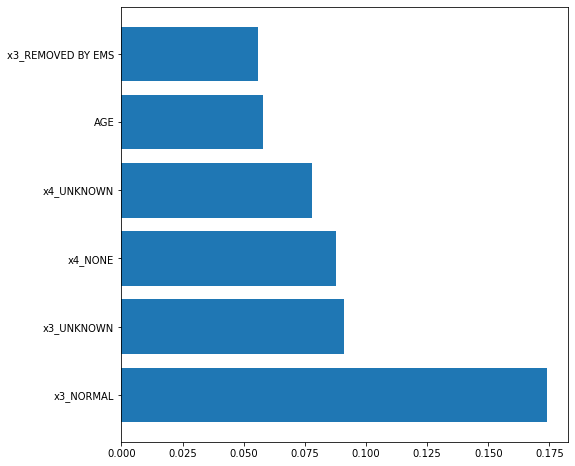

In [104]:
plt.figure(figsize=(8,8))
# forrest_labels = ['Physical Condition: Normal', 'Physical Condition: Unknown',
#             'Vehical Defect: None', 'Vehical Defect: Unknown', 'Lighting Conditioning: Darkness, Lighted Road',
#                  'Age', 'Traffic Control Device: No Controls']
# , tick_label=forrest_labels
plt.barh(forrest_features_names, forrest_features_values, align='center');

In [118]:
forest_cv_df = pd.DataFrame(forrest_grid_search.cv_results_)
forest_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,40.657806,0.613633,0.983081,0.025953,sqrt,1,2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997378,0.999974,0.999983,0.999923,0.999940,0.999440,0.001031,2
1,40.896808,0.785542,0.986615,0.022007,sqrt,1,5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997386,0.999949,0.999957,0.999932,0.999949,0.999435,0.001024,3
2,40.982208,1.007826,0.984053,0.028136,sqrt,1,10,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997378,0.999923,0.999932,0.999915,0.999923,0.999414,0.001018,5
3,40.741760,0.905145,0.959426,0.027666,sqrt,2,2,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.997421,0.999932,0.999915,0.999880,0.999898,0.999409,0.000994,6
4,40.937377,0.919016,0.966049,0.030101,sqrt,2,5,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.997361,0.999906,0.999906,0.999863,0.999872,0.999382,0.001011,9
